In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import polars as pl

In [ ]:
# paths:
csv_path = "/content/drive/MyDrive/DL_project/dataset/spotify_million_playlist_dataset_unzipped/csv/tracks_and_playlists.csv"


In [ ]:
# Define the path and columns to load
cols = [
    "track_pos",           # for ordering later
    "track_track_name",
    "track_artist_name",
    "playlist_pid"
]


In [ ]:
# Read CSV (only needed columns)
df = pl.read_csv(
    csv_path,
    columns=cols,
    use_pyarrow=True
)


In [ ]:
# Create a unique “track_key” by combining name & artist
df = df.with_columns([
    pl.concat_str([
        pl.col("track_track_name"),
        pl.lit("––"),
        pl.col("track_artist_name")
    ]).alias("track_key")
])

In [ ]:
# Create a mapping DataFrame: each unique track_key → an integer ID
track_map = (
    df.select("track_key")
      .unique()
      .with_row_count("track_id")   # adds a 0-based row count column called "track_id"
)


/tmp/ipython-input-8-197254295.py:5: DeprecationWarning: `DataFrame.with_row_count` is deprecated. Use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  .with_row_count("track_id")   # adds a 0-based row count column called "track_id"


In [ ]:
# Join it back onto your main df
df = df.join(track_map, on="track_key", how="left")

In [ ]:
# Inspect
print(f"Vocabulary size: {track_map.height} unique tracks")
print(df.select(["track_pos","track_key","track_id","playlist_pid"]).head(10))

Vocabulary size: 2189699 unique tracks
shape: (10, 4)
┌───────────┬─────────────────────────────────┬──────────┬──────────────┐
│ track_pos ┆ track_key                       ┆ track_id ┆ playlist_pid │
│ ---       ┆ ---                             ┆ ---      ┆ ---          │
│ i64       ┆ str                             ┆ u32      ┆ i64          │
╞═══════════╪═════════════════════════════════╪══════════╪══════════════╡
│ 0         ┆ Lose Control (feat. Ciara & Fa… ┆ 1837200  ┆ 0            │
│ 1         ┆ Toxic––Britney Spears           ┆ 976779   ┆ 0            │
│ 2         ┆ Crazy In Love––Beyoncé          ┆ 730973   ┆ 0            │
│ 3         ┆ Rock Your Body––Justin Timberl… ┆ 2096976  ┆ 0            │
│ 4         ┆ It Wasn't Me––Shaggy            ┆ 1418236  ┆ 0            │
│ 5         ┆ Yeah!––Usher                    ┆ 1261738  ┆ 0            │
│ 6         ┆ My Boo––Usher                   ┆ 673764   ┆ 0            │
│ 7         ┆ Buttons––The Pussycat Dolls     ┆ 1372992  ┆

In [ ]:
# Group by playlist, sort by track_pos, and collect track_id lists:
seqs = (
    df.sort(["playlist_pid","track_pos"])
      .group_by("playlist_pid")
      .agg(pl.col("track_id").alias("track_sequence"))
)

# Peek at one sequence:
print(seqs.head(3))

shape: (3, 2)
┌──────────────┬───────────────────────────────┐
│ playlist_pid ┆ track_sequence                │
│ ---          ┆ ---                           │
│ i64          ┆ list[u32]                     │
╞══════════════╪═══════════════════════════════╡
│ 0            ┆ [1837200, 976779, … 2046865]  │
│ 1            ┆ [1901930, 1354588, … 1728671] │
│ 2            ┆ [1496849, 384255, … 526620]   │
└──────────────┴───────────────────────────────┘


In [ ]:
track_map.filter(pl.col("track_id") == 1).select("track_key").head()

track_key
str
"""Underneath––Chelsea Wolfe"""


### saving

In [ ]:
# Estimate memory usage in MB
df_mem    = df.estimated_size()           # bytes
map_mem   = track_map.estimated_size()    # bytes

print(f"Main DataFrame size:       {df_mem/1024**2:.2f} MB")
print(f"Track‐map DataFrame size:   {map_mem/1024**2:.2f} MB")


Main DataFrame size:       5254.40 MB
Track‐map DataFrame size:   90.04 MB


In [ ]:
# 1. Save the full DataFrame with track_id
df.write_parquet(
    "/content/drive/MyDrive/DL_project/dataset/tokens/tracks_with_ids.parquet"
)

# 2. Save the mapping table
track_map.write_parquet(
    "/content/drive/MyDrive/DL_project/dataset/tokens/track_map.parquet"
)

# Reload using:
# df        = pl.read_parquet("/content/drive/MyDrive/DL_project/dataset/tokens/tracks_with_ids.parquet")
# track_map = pl.read_parquet("/content/drive/MyDrive/DL_project/dataset/tokens/track_map.parquet")

### some statistics to better understand the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import polars as pl
# read just the first million rows to get a feel
df = pl.read_csv('/content/drive/MyDrive/DL_project/dataset/spotify_million_playlist_dataset_unzipped/csv/tracks_and_playlists.csv', n_rows=1_000_000)
df.head()


Mounted at /content/drive


track_pos,track_track_name,track_album_name,track_artist_name,track_duration_ms,playlist_pid,playlist_name,playlist_description,playlist_modified_at,playlist_num_artists,playlist_num_albums,playlist_num_tracks,playlist_num_followers,playlist_num_edits,playlist_duration_ms,playlist_collaborative
i64,str,str,str,i64,i64,str,str,i64,i64,i64,i64,i64,i64,i64,bool
0,"""Lose Control (feat. Ciara & Fa…","""The Cookbook""","""Missy Elliott""",226863,0,"""Throwbacks""",null,1493424000,37,47,52,1,6,11532414,false
1,"""Toxic""","""In The Zone""","""Britney Spears""",198800,0,"""Throwbacks""",null,1493424000,37,47,52,1,6,11532414,false
2,"""Crazy In Love""","""Dangerously In Love (Alben für…","""Beyoncé""",235933,0,"""Throwbacks""",null,1493424000,37,47,52,1,6,11532414,false
3,"""Rock Your Body""","""Justified""","""Justin Timberlake""",267266,0,"""Throwbacks""",null,1493424000,37,47,52,1,6,11532414,false
4,"""It Wasn't Me""","""Hot Shot""","""Shaggy""",227600,0,"""Throwbacks""",null,1493424000,37,47,52,1,6,11532414,false


In [ ]:
df.head(10)

track_pos,track_track_name,track_album_name,track_artist_name,track_duration_ms,playlist_pid,playlist_name,playlist_description,playlist_modified_at,playlist_num_artists,playlist_num_albums,playlist_num_tracks,playlist_num_followers,playlist_num_edits,playlist_duration_ms,playlist_collaborative
i64,str,str,str,i64,i64,str,str,i64,i64,i64,i64,i64,i64,i64,bool
0,"""Lose Control (feat. Ciara & Fa…","""The Cookbook""","""Missy Elliott""",226863,0,"""Throwbacks""",null,1493424000,37,47,52,1,6,11532414,false
1,"""Toxic""","""In The Zone""","""Britney Spears""",198800,0,"""Throwbacks""",null,1493424000,37,47,52,1,6,11532414,false
2,"""Crazy In Love""","""Dangerously In Love (Alben für…","""Beyoncé""",235933,0,"""Throwbacks""",null,1493424000,37,47,52,1,6,11532414,false
3,"""Rock Your Body""","""Justified""","""Justin Timberlake""",267266,0,"""Throwbacks""",null,1493424000,37,47,52,1,6,11532414,false
4,"""It Wasn't Me""","""Hot Shot""","""Shaggy""",227600,0,"""Throwbacks""",null,1493424000,37,47,52,1,6,11532414,false
5,"""Yeah!""","""Confessions""","""Usher""",250373,0,"""Throwbacks""",null,1493424000,37,47,52,1,6,11532414,false
6,"""My Boo""","""Confessions""","""Usher""",223440,0,"""Throwbacks""",null,1493424000,37,47,52,1,6,11532414,false
7,"""Buttons""","""PCD""","""The Pussycat Dolls""",225560,0,"""Throwbacks""",null,1493424000,37,47,52,1,6,11532414,false
8,"""Say My Name""","""The Writing's On The Wall""","""Destiny's Child""",271333,0,"""Throwbacks""",null,1493424000,37,47,52,1,6,11532414,false


In [ ]:
total_playlists = df['playlist_pid'].n_unique()
# total_tracks    = df['track_id'].n_unique()

In [ ]:
import matplotlib.pyplot as plt

Unique tracks:   2189699
Unique playlists:1000000


/tmp/ipython-input-17-303731878.py:32: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias("count"))



Top 20 tracks by occurrence:
                                            track_key  count
0                             HUMBLE.––Kendrick Lamar  46574
1                                    One Dance––Drake  43447
2                   Broccoli (feat. Lil Yachty)––DRAM  41309
3                            Closer––The Chainsmokers  41079
4                        Congratulations––Post Malone  39987
5                                     Caroline––Aminé  35202
6                       iSpy (feat. Lil Yachty)––KYLE  35138
7          Bad and Boujee (feat. Lil Uzi Vert)––Migos  34999
8                                    Location––Khalid  34990
9                         XO TOUR Llif3––Lil Uzi Vert  34922
10                              Bounce Back––Big Sean  33699
11                         Ignition - Remix––R. Kelly  32391
12                            No Role Modelz––J. Cole  32336
13                                   Mask Off––Future  32059
14  No Problem (feat. Lil Wayne & 2 Chainz)––Chanc...  

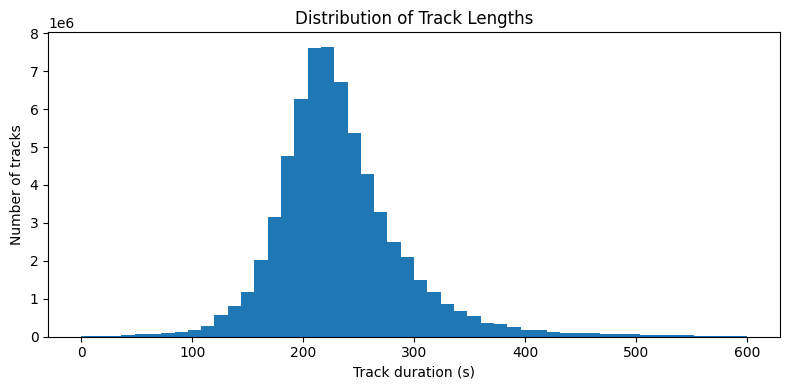

In [ ]:
# Load only the columns we need
cols = [
    "track_track_name",
    "track_artist_name",
    "track_duration_ms",
    "playlist_pid"
]
eda = pl.read_csv(
    "/content/drive/MyDrive/DL_project/dataset/spotify_million_playlist_dataset_unzipped/csv/tracks_and_playlists.csv",
    columns=cols,
    use_pyarrow=True
)

# Create a unique “track key” by combining name & artist
eda = eda.with_columns([
    pl.concat_str([
        pl.col("track_track_name"),
        pl.lit("––"),
        pl.col("track_artist_name")
    ]).alias("track_key")
])

# Count unique tracks & playlists
n_tracks    = eda["track_key"].n_unique()
n_playlists = eda["playlist_pid"].n_unique()
print(f"Unique tracks:   {n_tracks}")
print(f"Unique playlists:{n_playlists}")

# Top-20 most frequent tracks
top20 = (
    eda.group_by("track_key")
      .agg(pl.count().alias("count"))
      .sort("count", descending=True)
      .head(20)
      .to_pandas()   # for nicer display
)
print("\nTop 20 tracks by occurrence:")
print(top20)

# Histogram of track durations
#    Convert ms → seconds for readability
durations_s = eda["track_duration_ms"] / 1000

plt.figure(figsize=(8,4))
plt.hist(durations_s, bins=50, range=(0,600))  # cap at 10 minutes
plt.xlabel("Track duration (s)")
plt.ylabel("Number of tracks")
plt.title("Distribution of Track Lengths")
plt.tight_layout()
plt.show()

/tmp/ipython-input-22-607028556.py:5: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias("length"))          # count tracks per playlist


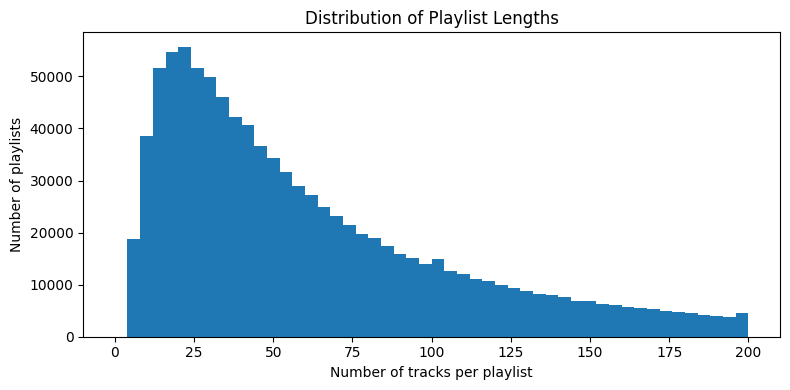

In [ ]:
# Histogram of playlist lengths (# of tracks per playlist)
playlist_lengths = (
    eda
    .group_by("playlist_pid")                 # or .groupby("playlist_pid") if that’s your Polars version
    .agg(pl.count().alias("length"))          # count tracks per playlist
    .select("length")                         # keep only the counts
    .to_pandas()                              # for plotting
)

import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.hist(playlist_lengths["length"], bins=50, range=(0,200))
plt.xlabel("Number of tracks per playlist")
plt.ylabel("Number of playlists")
plt.title("Distribution of Playlist Lengths")
plt.tight_layout()
plt.show()


In [ ]:
# Compute track‐counts per playlist, then take the minimum
min_length = (
    eda
      .group_by("playlist_pid")
      .agg(pl.count().alias("length"))
      .select(pl.col("length").min())
      .item()
)

print(f"Minimum playlist length: {min_length} tracks")


/tmp/ipython-input-21-4258902469.py:5: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias("length"))


Minimum playlist length: 5 tracks
